In [735]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

In [736]:
idx = 3

ref_list = ['ref_2022-11-18_17-29-11_left_0.png',
            'ref_2022-11-18_17-29-11_right_0.png',
            'ref_2022-11-21_21-14-25_left_0.png',
            'ref_2022-11-21_21-14-25_right_0.png',
            'ref_2022-11-23_18-42-03_left_0.png',
            'ref_2022-11-23_18-42-03_right_0.png',
            'ref_2022-11-23_19-07-54_left_0.png',
            'ref_2022-11-23_19-07-54_right_0.png']

img_list = ['2022-11-18_17-29-11_left_119.png',
            '2022-11-18_17-29-11_right_119.png',
            '2022-11-21_21-14-25_left_113.png',
            '2022-11-21_21-14-25_right_113.png',
            '2022-11-23_18-42-03_left_114.png',
            '2022-11-23_18-42-03_right_121.png',
            '2022-11-23_19-07-54_left_105.png',
            '2022-11-23_19-07-54_right_125.png']

img1 = cv2.imread('needle_images_new/' + ref_list[idx])
img2 = cv2.imread('needle_images_new/' + img_list[idx])

bb_list = np.array([[550, 90, 750, 800],
                    [750, 70, 950, 800],
                    [720, 130, 920, 850],
                    [900, 100, 1100, 850],
                    [700, 120, 900, 850],
                    [900, 90, 1100, 900],
                    [650, 120, 850, 800],
                    [850, 90, 1100, 900],])

In [737]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp1 = orb.detect(img1,None)
kp2 = orb.detect(img2,None)

# compute the descriptors with ORB
kps1, des1 = orb.compute(img1, kp1)
kps2, des2 = orb.compute(img2, kp2)

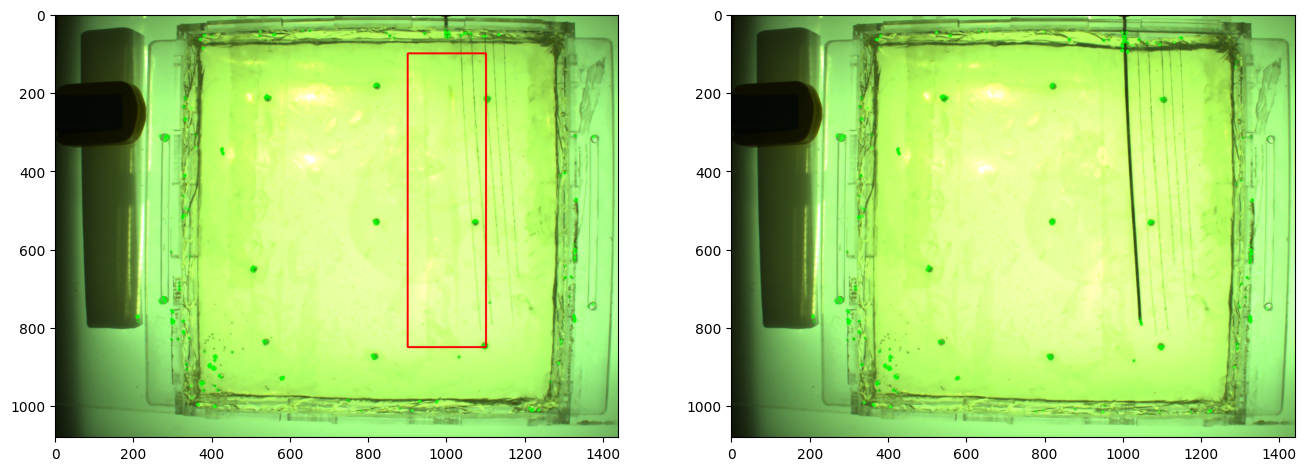

In [738]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

kp_img1 = cv2.rectangle(kp_img1, bb_list[idx,:2],  bb_list[idx,2:], [0,0,255], 3)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

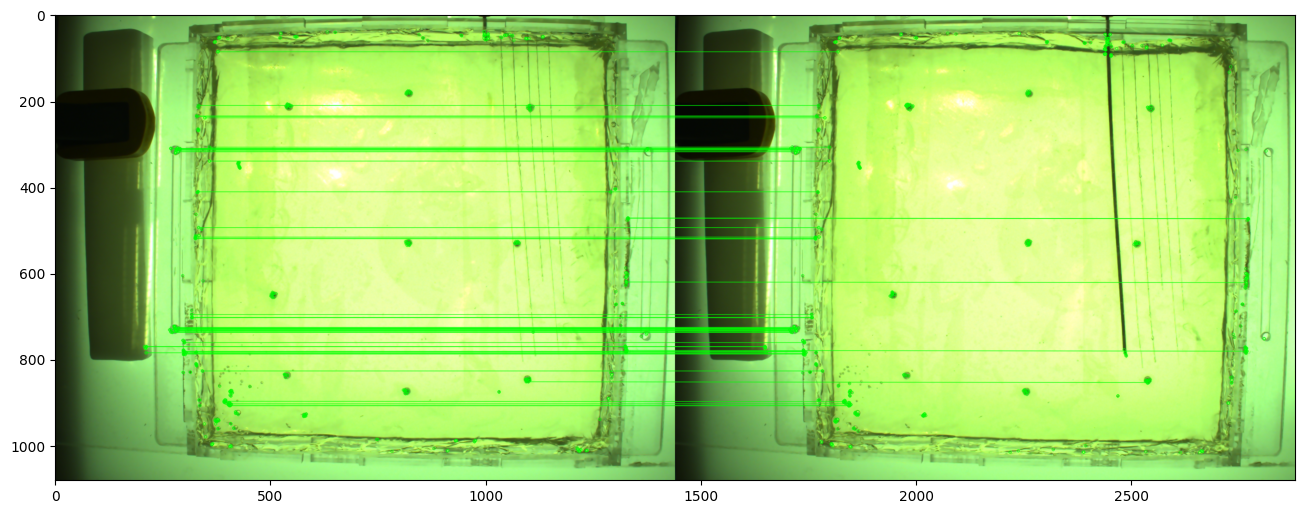

In [739]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:50], None,
    matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

In [740]:
def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    
    # construct A matrix
    A = np.zeros([len(pts1)*2, 9])
    r = 0
    for i in range(len(pts1)):
        A[r  ,:] = [pts1[i][0], pts1[i][1], 1, 0, 0, 0, -pts2[i][0]*pts1[i][0], -pts2[i][0]*pts1[i][1], -pts2[i][0] ]
        A[r+1,:] = [0, 0, 0, pts1[i][0], pts1[i][1], 1, -pts2[i][1]*pts1[i][0], -pts2[i][1]*pts1[i][1], -pts2[i][1] ]
        r = r + 2
        
    # find smallest eigen-vector of A.T @ A
    u, s, vh = np.linalg.svd(A)
    
    # reconstruct t
    t = np.reshape(vh[-1], (3,3))
    t = t / t[-1][-1]
    
    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]

t = get_homography(pts1, pts2)
print(t)


[[ 8.90377359e-01  3.14823851e-01 -4.23004207e+01]
 [-1.76643239e-01  9.37755317e-01  1.52506375e+02]
 [ 2.09312654e-04 -1.95389663e-05  1.00000000e+00]]


In [741]:
import random


def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
    """Estimate the transformation between two matching lists of keypoints 
    using RANSAC.
    
    Args:
    - kps1: A list of `cv2.KeyPoint` objects.
    - kps2: A list of `cv2.KeyPoint` objects.
    - matches: A list of `cv2.DMatch` objects representing the matches
          between `kps1` and `kps2`.
    - transform_func: Function used to estimate the transformation given
          matching points.
    - n_samples: The number of samples in each RANSAC trial.
    - n_trials: The total number of RANSAC trials.
    - inlier_thresh: The threshold used to determine whether a match is an
          inlier or not.
    
    Returns:
    - transform: The 3x3 transformation matrix that maps kps1 to kps2.
    - mask: A list of Boolean values representing whether the corresponding
          match is an inlier or not.
    """
    
    # change kps1 and kps2 to numpy array
    kp1 = np.array([ kps1[match.queryIdx].pt for match in matches ])
    kp2 = np.array([ kps2[match.trainIdx].pt for match in matches ])
    
    # add one column for homogeneous transformation
    kp1_ht = np.append(kp1, np.ones((kp1.shape[0],1)), axis=1)

    inlier_max = 0
    
    for nt in range(n_trials):
        
        # sample matches
        sp_matches = random.sample(range(len(matches)), n_samples)
        sp_kp1 = [ kp1[sp_match, :] for sp_match in sp_matches ]
        sp_kp2 = [ kp2[sp_match, :] for sp_match in sp_matches ]
        
        # find transformation
        sp_transform = transform_func(sp_kp1, sp_kp2)
        
        # find inlier and outlier
        kp2_tf = kp1_ht @ sp_transform.T
        kp2_tf = kp2_tf[:,:2] / kp2_tf[:,2:]
        error = np.linalg.norm(kp2 - kp2_tf, axis=1)
        sp_mask = error < inlier_thresh
        
        # update best
        if inlier_max < sum(sp_mask):
            inlier_max = sum(sp_mask)
            transform = sp_transform
            mask = sp_mask

    return transform, mask

transform, mask = estimate_transformation_ransac(kps1, kps2, matches, 
                                                 transform_func=get_homography,
                                                 n_samples=5, 
                                                 n_trials=100, 
                                                 inlier_thresh=5)

print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[ 1.00166332e+00  3.72940790e-04 -4.38154373e-01]
 [ 2.73679172e-03  1.00146863e+00 -1.07470873e+00]
 [ 3.76876982e-07  1.34784504e-06  1.00000000e+00]].
244 out of 274 matches are inliers.


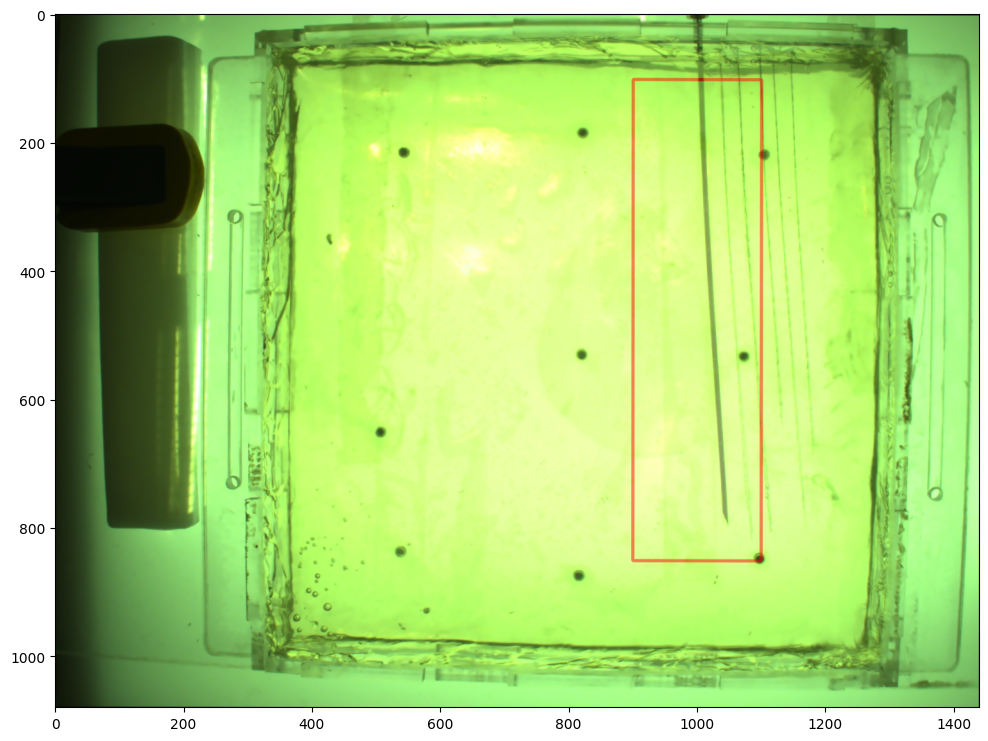

In [742]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    img1_bb = cv2.rectangle(img1.copy(), bb_list[idx,:2],  bb_list[idx,2:], [0,0,255], 3)

    # Warp input images and overlay them.
    # print((w, h))
    # warped_img1 = cv2.warpPerspective(img1_bb, shift @ transform, (w, h))
    # warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    # overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    # print(overlayed_img.shape)
    warped_img1 = cv2.warpPerspective(img1_bb, transform, (img2.shape[1],img2.shape[0]))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, img2, 0.5, 0.0)
    return overlayed_img

stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

[[ 901 1100]
 [ 101  852]]
(1080, 1440)


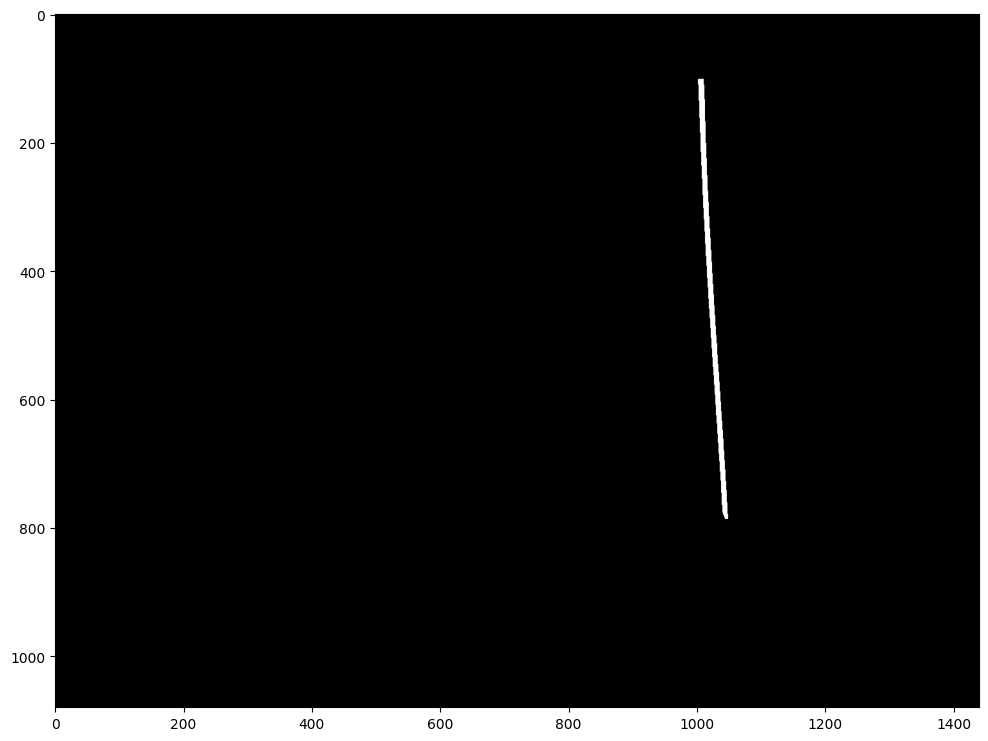

In [743]:
warped_ref = cv2.warpPerspective(img1, transform, (img2.shape[1],img2.shape[0]))

img_diff = np.abs( cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(warped_ref, cv2.COLOR_BGR2GRAY) )

bb = np.concatenate((bb_list[idx,:].reshape((2,2)).T, [[1, 1]]))
bb_ = transform @ bb
bb_ = np.round(bb_[0:2, :] / bb_[2, :]).astype(int)
print(bb_)
print(img_diff.shape)
# bb_tranform = [ bb_list[idx,:2]@transform.T, bb_list[idx,2:]@transform.T ]
# print([bb_list[idx,:2], 1]@transform.T)

mask = np.zeros(img_diff.shape)
mask[bb_[1,0]:bb_[1,1], bb_[0,0]:bb_[0,1]] = img_diff[bb_[1,0]:bb_[1,1], bb_[0,0]:bb_[0,1]]

mask[ np.bitwise_or(mask>200, mask<50) ] = 0
mask[ mask!=0 ] = 1

kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(mask, cmap='gray')

plt.show()

